# PREDICTION OF THE ENSO INDEX
Gavin LEROY and Aurélie PANETIER
- Regression problem
- Oceanography/Climate
- Based on the code from Pierre Tandeo (pierre.tandeo@imt-atlantique.fr) and Ronan Fablet (ronan.fablet@imt-atlantique.fr)

The first part of the study we realized was share with the two other students Alix Lamouroux and Yann lambretchs to analyze the phenomenon on 10 years of daily data with a common basis.

## Data and aim

The database used in this project is coming from NOAA ERSST for Extended Reconstructed Sea Surface Temperature (more details here: https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v4). They correspond to monthly maps of SST anomalies (from a 1971-2000 climatology) in the global ocean. It takes into account in situ measurements (buoys, ships) and satellite observations (since the 70th). Data are available between 1854 and 2017.

The goal is to predict the ENSO index calculated from averaged SST anomalies over the El Nino 3.4 region, 6 months ahead. Below, you will find an explanation of El Nino and La Nina.

## Evaluation and benchmark

You will use SST anomaly fields to predict ENSO index 6 month ahead using regression approaches. To evaluate and compare the results, we propose to use a cross validation, repeated 100 times on 70% of training and 30% of validation. The reference score is **RMSE=0.42**. Then, we propose to test the methodology on the prediction of the last 10 years and try to see if you are able to predict the last big El Nino event in 2009-2010 and 2015-2016. As a final part, we apply a SVR method as a non-linear regression and develop the same protocol as above.

## References
- http://journals.ametsoc.org/doi/pdf/10.1175/1520-0477%281997%29078%3C2771%3ATDOENO%3E2.0.CO%3B2 (for more information regarding the ENSO index and how to calculate it from SST)
- https://drive.google.com/file/d/0B-oKhfYlOUQaZFRfRmMwSjREdUk/view?usp=sharing (for an overview of existing statistical methods to predict the ENSO index)
- http://journals.ametsoc.org/doi/abs/10.1175/1520-0442(2001)013%3C3953:LLPOPS%3E2.0.CO;2 (reference paper on the prediction of ENSO using statistical approaches)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libraries

First, we import the Python libraries we will use during this project. The main one are netCDF4 (to read netcdf files) and scikit-learn (for machine learning).

In [0]:
# import classical libraries
%matplotlib inline
%pylab inline
import pyresample

# import machine learning library
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from scipy.stats.mstats import zscore
from sklearn.svm import SVR
import netCDF4 as nc
from datetime import date

# figure size
plt.rcParams['figure.figsize'] = (16, 9)

Populating the interactive namespace from numpy and matplotlib


### Import and plot data

Here, we import the full netcdf file of the 163 years of SST anomalies in the Equatorial Pacific. We will use "lon", "lat", "time" and "sst_ano" for longitude, latitude, time and sea surface temperature anomaly. Note that you can select a subsample of the dataset, selecting the time period (i_good_time).

[676834.78515625 676865.203125   676895.6171875  ... 736391.26953125
 736421.6875     736452.10351562]


Text(0.5, 1.0, 'Example of global SST anomaly field')

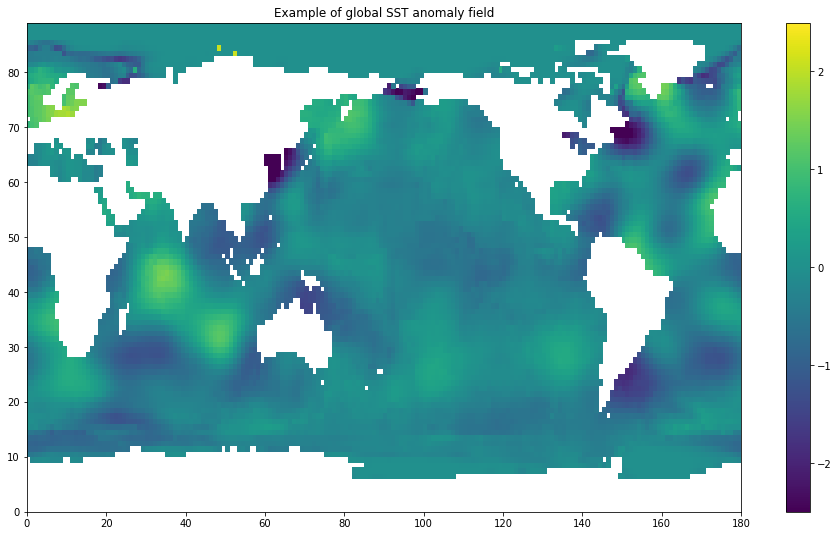

In [0]:
# load netcdf file
data_ERSST = nc.Dataset("/content/drive/My Drive/Colab Notebooks/data_ERSST.nc")

# extract lon, lat, time, sst_ano
lon = data_ERSST.variables['X'][:]
lat = data_ERSST.variables['Y'][:]
time_tmp = data_ERSST.variables['T'][:]*30.417 + date(1960,1,1).toordinal()
sst_ano_tmp = data_ERSST.variables['anom'][:]

# select a sample of the dataset
i_good_time = np.where((time_tmp>=date(1854,1,1).toordinal()) & (time_tmp<=date(2018,1,1).toordinal())) # select a specific period
time_good = time_tmp[i_good_time[0]]
sst_ano = sst_ano_tmp[i_good_time[0],0,:,:]

# plot a sample of data
pcolor(sst_ano[100,:,:]);clim([-2.5,2.5]);colorbar()
title('Example of global SST anomaly field')

### Compute the ENSO index

To compute the ENSO index, we average the SST anomalies in the Tropical Pacific (El Nino 3.4 region). The El Nino/La Nina threshold is $0.5^\circ$ Celsius. The plot displays the warm periods as red (El Nino) and cold periods (La Nina) as blue. To be precise, El Nino requires a period of consecutive three months with mean temperatures $0.5^\circ$ Celsius above the seasonal average.

[676834.78515625 676865.203125   676895.6171875  ... 736391.26953125
 736421.6875     736452.10351562]


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Corrected ENSO index')

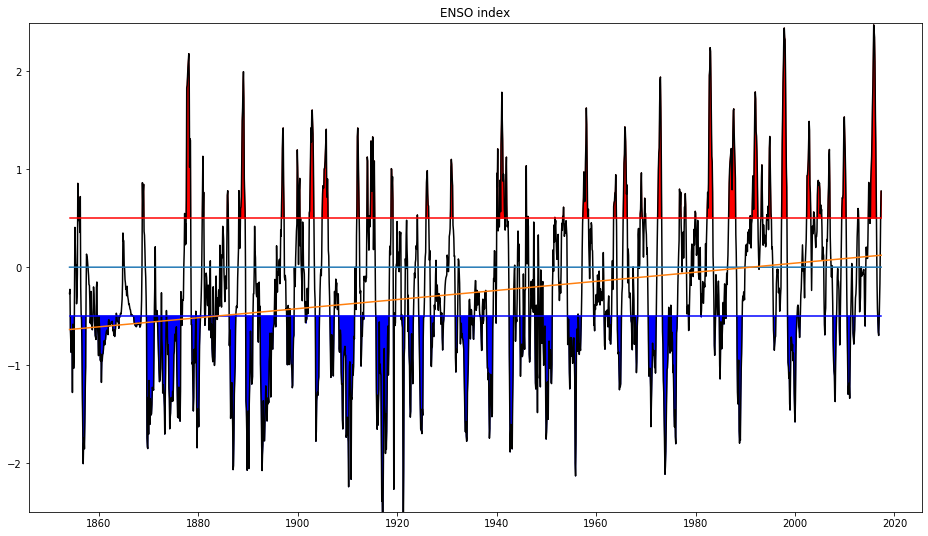

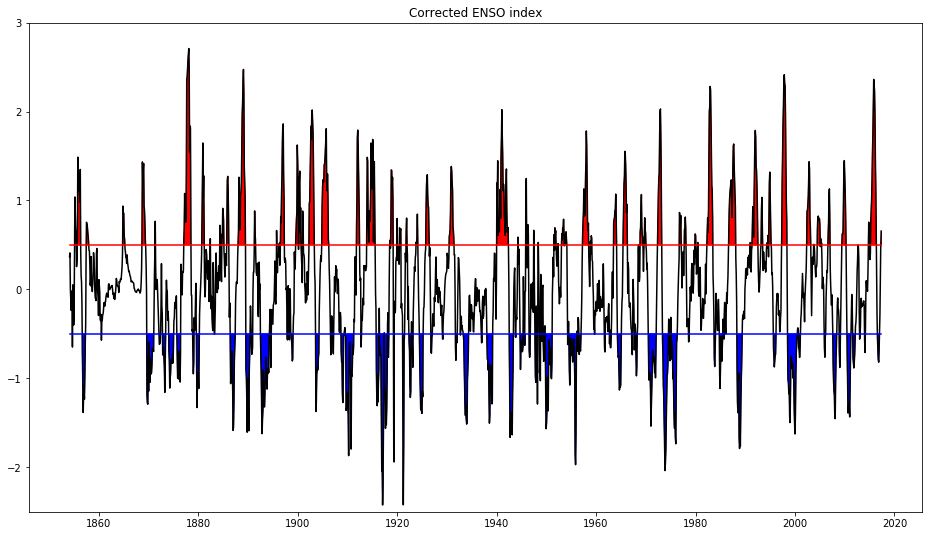

In [0]:
# select ENSO region (El Nino 3.4 region)
i_good_lon_tmp = np.where((lon>=190) & (lon<=240))[0]
i_good_lat_tmp = np.where((lat>=-5) & (lat<=5))[0]
i_good_lon, i_good_lat = ix_(i_good_lon_tmp,i_good_lat_tmp)

# extract ENSO index
enso = mean(mean(sst_ano[:,i_good_lat,i_good_lon], axis=2), axis=1)

# plot ENSO index
plot_date(time_good, enso, '-k')
plt.plot(time_good, np.zeros_like(time_good))
xrange = np.arange(0,len(enso))
y = enso
x_limits = [min(time_good), max(time_good)]
y_limits = [-2.5, 2.5]
el_nino_threshold = 0.5
plot(x_limits, [el_nino_threshold, el_nino_threshold], c='r')
plot(x_limits, [-el_nino_threshold, -el_nino_threshold], c='b')
fill_between(time_good, el_nino_threshold, y, color='red', 
             where=y>=el_nino_threshold, interpolate=True)
fill_between(time_good, -el_nino_threshold, y, color='blue', 
             where=y<=-el_nino_threshold)
ylim([-2.5,2.5])
title('ENSO index')

# compute linear regression to correct the ascending trend over the years
# Linear Model 
model= LinearRegression()

model.fit(time_good[:,None],enso[:,None])

# get the predicted values of enso using the linear regression model
enso_hat = model.predict(time_good[:,None])

# plot the general ascending tendancy
plot_date(time_good, enso_hat, '-', "ENSO estimated (m)")

# compute the correction
enso_corr = enso - enso_hat[:,0]

# plot the corrected enso 
figure()
plot_date(time_good, enso_corr, '-k')
plot(x_limits, [el_nino_threshold, el_nino_threshold], c='r')
plot(x_limits, [-el_nino_threshold, -el_nino_threshold], c='b')
fill_between(time_good, el_nino_threshold, enso_corr, color='red', where=enso_corr>=el_nino_threshold, interpolate=True)
fill_between(time_good, -el_nino_threshold, enso_corr, color='blue', where=enso_corr<=-el_nino_threshold)
ylim([-2.5,3])
title('Corrected ENSO index')

### Feature extraction

Here, we declare the input variable $X$ (map of SST anomalies in the El Nino 3.4 region at month $m$) and the response variable $y$ (ENSO index at month $m+6$). Note that other SST anomalies can be used (larger region, delayed times, etc...).

In [0]:
# regional SST anomalies (can be different than the El Nino 3.4 region)
i_good_lon_tmp_X = np.where((lon>=190) & (lon<=240))[0]
i_good_lat_tmp_X = np.where((lat>=-5) & (lat<=5))[0]
i_good_lon_X, i_good_lat_X = ix_(i_good_lon_tmp_X,i_good_lat_tmp_X)     
sst_ano_region = sst_ano[:,i_good_lat_X,i_good_lon_X]

# ENSO index (do not change that!)
i_good_lon_tmp_y = np.where((lon>=190) & (lon<=240))[0]
i_good_lat_tmp_y = np.where((lat>=-5) & (lat<=5))[0]
i_good_lon_y, i_good_lat_y = ix_(i_good_lon_tmp_y,i_good_lat_tmp_y)
enso = enso_corr

# select times (SST anomalies at month m and ENSO index at month m+6)
time_steps, nb_lat, nb_lon = shape(sst_ano_region)
time_good_X = range(0,time_steps-5)
time_good_y = range(5,time_steps)

# generate X and y
X = reshape(sst_ano_region[time_good_X, :, :], (len(time_good_X), nb_lat*nb_lon))
y = enso_corr[time_good_y]

### Example of Ridge regression

Here, we declare the statistical regressors between $X$ and $y$. As an example, we use the linear regression using the Tikhonov regularization (also known as ridge regression).

In [0]:
# design the cross-validation
skf = ShuffleSplit(y.shape[0], test_size=.3, train_size=100, random_state=1)

# declare the regression model
reg = Ridge(alpha=.0001)

# compute the score by cross-validation
scores = np.sqrt(-cross_val_score(reg, X=X, y=y, scoring='neg_mean_squared_error', cv=skf))

# print mean RMSE
print('RMSE: ' + str(mean(scores)))

### Test the statistical predictor

Here, we learn the regression model on the first part of the time series and test the fit on the independant last part (10 years).

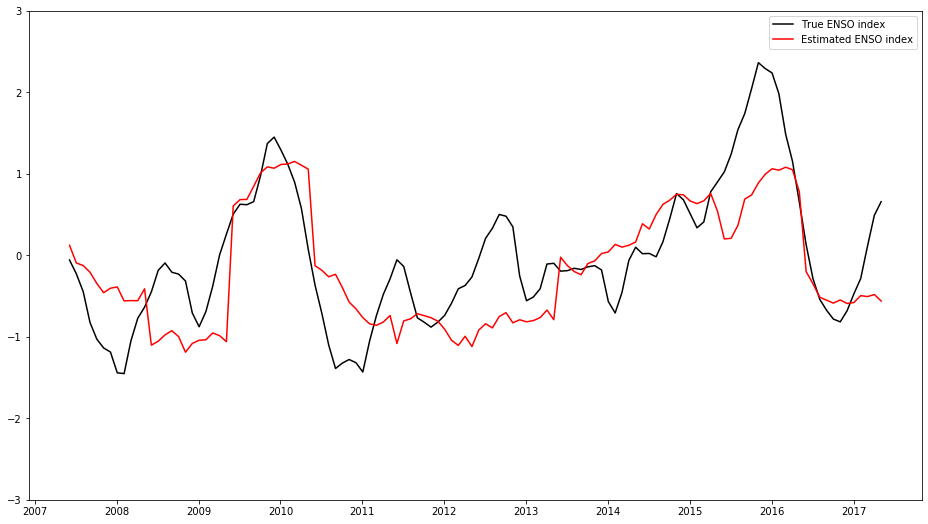

In [0]:
# train and test dataset
dt = 12*10 # last 10 years
X_train = X[0:len(y)-dt,:]
y_train = y[0:len(y)-dt]
X_test = X[-dt:,:]
y_test = y[-dt:]

# apply regression
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

# plot true and estimated ENSO index on the last 10 years
line1, = plot_date(time_good[-dt:], y_test, 'k')
line2, = plot_date(time_good[-dt:], y_hat, 'r')
ylim([-3,3])
legend([line1, line2], ['True ENSO index', 'Estimated ENSO index']) 

Use the non linear method SVR to predict enso within 6 months.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9853867796525869

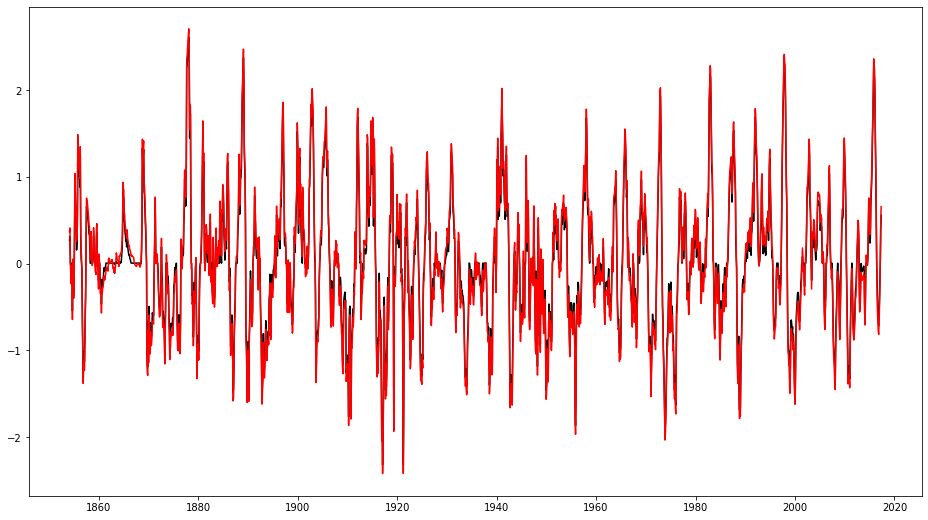

In [0]:
# compute SVR non linear regression to correct the ascending trend over the years
model = SVR(kernel='rbf', C=50, gamma=0.1)

model.fit(time_good[:,None],enso_corr[:,None])

# get the predicted values of enso using the non linear regression model
enso_hat_nonlin = model.predict(time_good[:,None])

# plot the general non linear tendancy
figure()
plot_date(time_good,enso_hat_nonlin,'-k',"ENSO estimated (m)")
plot_date(time_good, enso_corr, '-r')
model.score(time_good[:,None],enso_corr[:,None])

In [0]:
# regional SST anomalies (can be different than the El Nino 3.4 region)
i_good_lon_tmp_X = np.where((lon>=190) & (lon<=240))[0]
i_good_lat_tmp_X = np.where((lat>=-5) & (lat<=5))[0]
i_good_lon_X, i_good_lat_X = ix_(i_good_lon_tmp_X,i_good_lat_tmp_X)     
sst_ano_region = sst_ano[:,i_good_lat_X,i_good_lon_X]

# ENSO index (do not change that!)
i_good_lon_tmp_y = np.where((lon>=190) & (lon<=240))[0]
i_good_lat_tmp_y = np.where((lat>=-5) & (lat<=5))[0]
i_good_lon_y, i_good_lat_y = ix_(i_good_lon_tmp_y,i_good_lat_tmp_y)
enso = enso_corr

# select times (SST anomalies at month m and ENSO index at month m+6)
time_steps, nb_lat, nb_lon = shape(sst_ano_region)
time_good_X = np.arange(0,time_steps-5)
time_good_X_m1 = time_good_X - 1
time_good_X_m2 = time_good_X - 2
time_good_X_m3 = time_good_X - 3
time_good_X_m4 = time_good_X - 4
time_good_y = np.arange(5,time_steps)

# sst_ano_region tps, lon, lat = (1956, 26, 5)
# generate X and y
X1 = reshape(sst_ano_region[time_good_X,:,:],(len(time_good_X),nb_lat*nb_lon))
X2 = reshape(sst_ano_region[time_good_X_m1,:,:],(len(time_good_X_m1),nb_lat*nb_lon))
X3 = reshape(sst_ano_region[time_good_X_m2,:,:],(len(time_good_X_m2),nb_lat*nb_lon))
X4 = reshape(sst_ano_region[time_good_X_m3,:,:],(len(time_good_X_m3),nb_lat*nb_lon))
X5 = reshape(sst_ano_region[time_good_X_m4,:,:],(len(time_good_X_m4),nb_lat*nb_lon))
X = hstack((X2,X1))
y = enso_corr[time_good_y]

(1956, 260) (1956,)


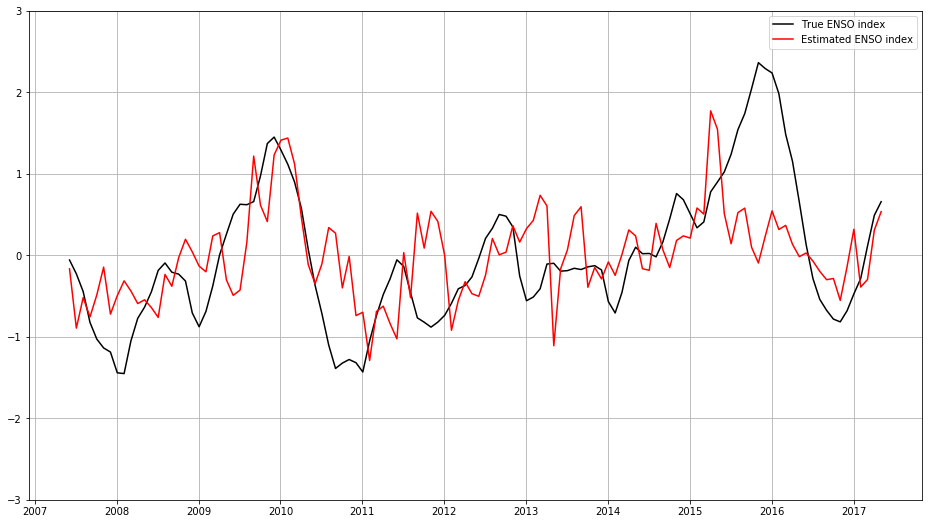

In [0]:
# train and test dataset
dt = 12*10 # last 10 years
X_train = X[0:len(y)-dt,:]
y_train = y[0:len(y)-dt]
X_test = X[-dt:,:]
y_test = y[-dt:]

# apply regression
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

# plot true and estimated ENSO index on the last 10 years
line1, = plot_date(time_good[-dt:], y_test, 'k')
line2, = plot_date(time_good[-dt:], y_hat, 'r')
ylim([-3,3])
grid()
legend([line1, line2], ['True ENSO index', 'Estimated ENSO index']) 